In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm

In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
def preprocess_data(dataset, encoder=None, fit_encoder=False):
    print(dataset.columns)
    dataset['Name'] = dataset['Name'].apply(lambda x: re.sub(r'"', '', x))
    dataset['Name_prefix'] = dataset['Name'].apply(lambda name: re.search(r'^(?:.*,)?(?:\s*)?(.*?\.)', name).group(1) if re.search(r'^(?:.*,)?(?:\s*)?(.*?\.)', name) else '')
    dataset['Ticket_type'] = dataset['Ticket'].apply(lambda x: x[0:3]).astype('category').cat.codes
    dataset['Name_prefix'] = dataset['Name_prefix'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    dataset.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
        
    mean, std = dataset['Age'].mean(), dataset['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    rand_age = np.random.randint(max(0, mean - std), mean + std, size=is_null)
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset['Age'] = age_slice.astype(int)

    embarked_mode = dataset['Embarked'].mode()[0]
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode)

    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset['travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'

    cat_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Name_prefix', 'travelled_alone', 'Ticket_type']
    cat_data = dataset[cat_features]

    if fit_encoder:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cat = encoder.fit_transform(cat_data)
    else:
        encoded_cat = encoder.transform(cat_data)

    # Convert encoded data into a DataFrame
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_features))
    encoded_cat_df.index = dataset.index

    dataset.drop(cat_features, axis=1, inplace=True)
    dataset = pd.concat([dataset, encoded_cat_df], axis=1)
    return dataset, encoder

In [5]:
class TitanicDataset(Dataset):
    def __init__(self, data, encoder=None):
        self.features = torch.tensor(data.drop(['Survived'], axis=1).values, dtype=torch.float32)
        self.targets = torch.tensor(data['Survived'].values, dtype=torch.long)
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [6]:
data_preprocessed, encoder = preprocess_data(df, fit_encoder=True)
train_data, test_data  = train_test_split(data_preprocessed, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataloader = DataLoader(TitanicDataset(train_data, encoder=encoder), batch_size=256, shuffle=True)
val_dataloader = DataLoader(TitanicDataset(test_data, encoder=encoder), batch_size=256, shuffle=False)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [7]:
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization
        self.dp1 = nn.Dropout(0.5)  # Dropout layer
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 2)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dp1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dp2(x)
        x = self.fc3(x)
        return x

In [8]:
num_features = train_data.shape[1] - 1
model = Net(num_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training and validation
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

n_epochs = 500
patience = 100
best_val_loss = float('inf')
trigger_times = 0

In [10]:
for epoch in range(n_epochs):
    model.train()
    train_losses_epoch = []
    train_correct = 0

    for batch_idx, (features, targets) in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.item())
        train_correct += (outputs.argmax(1) == targets).sum().item()

    # Scheduler step
    scheduler.step()

    # Training metrics
    train_accuracy = train_correct / len(train_dataloader.dataset)
    avg_train_loss = sum(train_losses_epoch) / len(train_losses_epoch)
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    val_losses_epoch = []
    val_correct = 0
    with torch.no_grad():
        for features, targets in tqdm(val_dataloader, desc="Validating", leave=False):
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_losses_epoch.append(loss.item())
            val_correct += (outputs.argmax(1) == targets).sum().item()

    # Validation metrics
    validation_accuracy = val_correct / len(val_dataloader.dataset)
    avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_accuracies.append(validation_accuracy)
    val_losses.append(avg_val_loss)

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        best_model = model.state_dict()
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            model.load_state_dict(best_model)
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Training Accuracy = {train_accuracy * 100:.2f}%, Average Loss = {avg_train_loss:.4f}")
        print(f"Validation Accuracy = {validation_accuracy * 100:.2f}%, Average Loss = {avg_val_loss:.4f}")

Epoch 10/500
Training Accuracy = 69.38%, Average Loss = 0.5992
Validation Accuracy = 71.51%, Average Loss = 0.5793


Epoch 20/500
Training Accuracy = 71.91%, Average Loss = 0.5596
Validation Accuracy = 74.86%, Average Loss = 0.5336


Epoch 30/500
Training Accuracy = 81.04%, Average Loss = 0.4539
Validation Accuracy = 82.12%, Average Loss = 0.4454


Epoch 40/500
Training Accuracy = 81.74%, Average Loss = 0.4291
Validation Accuracy = 82.12%, Average Loss = 0.4139


Epoch 50/500
Training Accuracy = 81.74%, Average Loss = 0.4128
Validation Accuracy = 81.56%, Average Loss = 0.4206


Epoch 60/500
Training Accuracy = 82.30%, Average Loss = 0.3900
Validation Accuracy = 82.12%, Average Loss = 0.4253


Epoch 70/500
Training Accuracy = 82.87%, Average Loss = 0.3890
Validation Accuracy = 82.12%, Average Loss = 0.4214


Epoch 80/500
Training Accuracy = 83.57%, Average Loss = 0.3949
Validation Accuracy = 82.12%, Average Loss = 0.4223


Epoch 90/500
Training Accuracy = 82.87%, Average Loss = 0.4062
Validation Accuracy = 81.56%, Average Loss = 0.4213


Epoch 100/500
Training Accuracy = 83.85%, Average Loss = 0.3757
Validation Accuracy = 82.12%, Average Loss = 0.4217


Epoch 110/500
Training Accuracy = 83.43%, Average Loss = 0.3979
Validation Accuracy = 82.12%, Average Loss = 0.4218


Epoch 120/500
Training Accuracy = 83.43%, Average Loss = 0.3866
Validation Accuracy = 81.56%, Average Loss = 0.4211


Epoch 130/500
Training Accuracy = 82.30%, Average Loss = 0.3898
Validation Accuracy = 81.56%, Average Loss = 0.4217


Epoch 140/500
Training Accuracy = 81.88%, Average Loss = 0.3990
Validation Accuracy = 81.56%, Average Loss = 0.4220


Early stopping at epoch 142


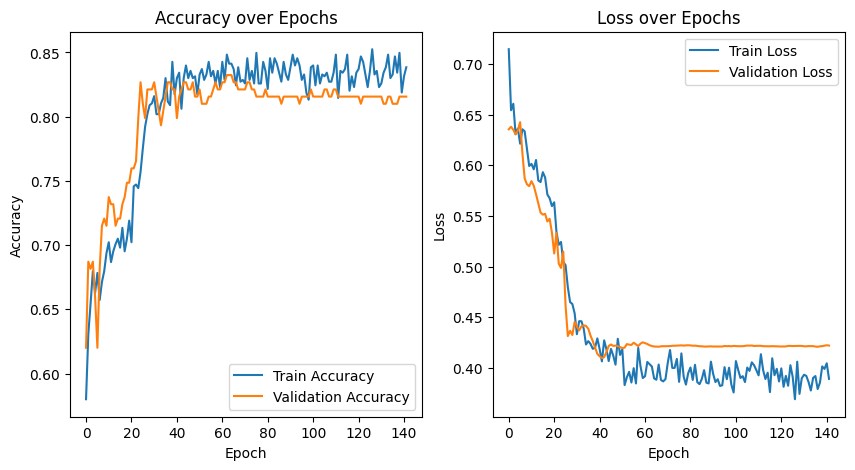

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [12]:
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

test_data_preprocessed, _ = preprocess_data(df_test, encoder=encoder, fit_encoder=False)
test_features = test_data_preprocessed.values

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [13]:
model.eval()


model.to(device)

# Make predictions
final_pred_labels = []
with torch.no_grad():
    for i in tqdm(range(0, len(test_features_tensor), 256), desc="Testing", leave=False):
        batch_features = test_features_tensor[i:i+256].to(device)
        outputs = model(batch_features)
        predictions = outputs.argmax(1)
        final_pred_labels.extend(predictions.cpu().numpy())


submission = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": final_pred_labels
})

submission.to_csv("submission.csv", index=False)

Score: 0.76794